<a href="https://colab.research.google.com/github/ChiriKamau/notebooks/blob/main/anyshape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

lets see

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:

# Known scale: 10 cm = 535 pixels
PIXELS_PER_10CM = 535
CM_PER_PIXEL = 10.0 / PIXELS_PER_10CM
CM2_PER_PIXEL2 = CM_PER_PIXEL ** 2

print(f"Scale: 1 pixel = {CM_PER_PIXEL:.6f} cm")


Scale: 1 pixel = 0.018692 cm


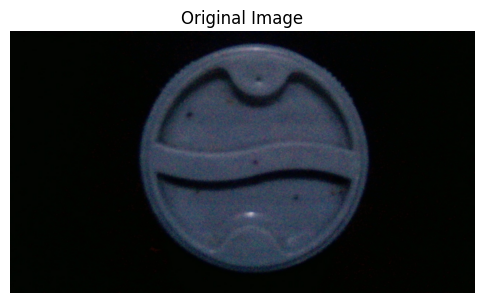

In [4]:
# Load image
import requests # Import the requests library

image_url = "https://raw.githubusercontent.com/ChiriKamau/notebooks/main/round_object.jpg"

# Use requests to get the image from the URL
response = requests.get(image_url)
# Convert the response content to a numpy array
image_array = np.array(bytearray(response.content), dtype=np.uint8)
# Decode the image array using OpenCV
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()

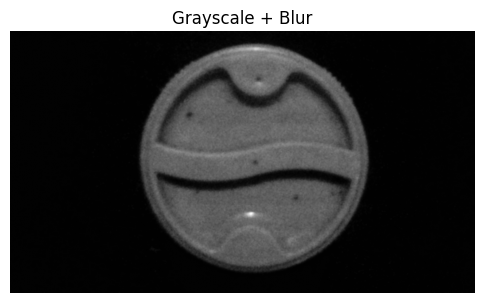

In [5]:
# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Reduce noise (important for accuracy)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

plt.figure(figsize=(6,6))
plt.imshow(blur, cmap="gray")
plt.title("Grayscale + Blur")
plt.axis("off")
plt.show()


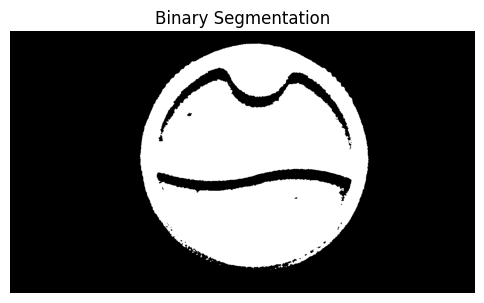

In [6]:
# Automatic threshold (Otsu)
_, segmentation = cv2.threshold(
    blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# Ensure object is white
if np.mean(segmentation) > 127:
    segmentation = cv2.bitwise_not(segmentation)

plt.figure(figsize=(6,6))
plt.imshow(segmentation, cmap="gray")
plt.title("Binary Segmentation")
plt.axis("off")
plt.show()


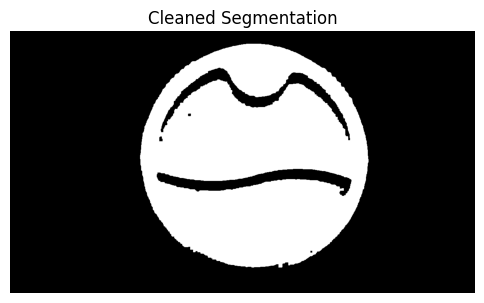

In [7]:
kernel = np.ones((5,5), np.uint8)

segmentation = cv2.morphologyEx(segmentation, cv2.MORPH_CLOSE, kernel)
segmentation = cv2.morphologyEx(segmentation, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(6,6))
plt.imshow(segmentation, cmap="gray")
plt.title("Cleaned Segmentation")
plt.axis("off")
plt.show()


In [8]:
contours, _ = cv2.findContours(
    segmentation,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_NONE   # best accuracy
)

largest_contour = max(contours, key=cv2.contourArea)

print(f"Detected contours: {len(contours)}")


Detected contours: 1


In [9]:
# Sub-pixel contour area
area_pixels = cv2.contourArea(largest_contour)
area_cm2 = area_pixels * CM2_PER_PIXEL2

print(f"Area: {area_pixels:.2f} pixels²")
print(f"Area: {area_cm2:.4f} cm²")


Area: 302220.50 pixels²
Area: 105.5884 cm²


In [10]:
# Perimeter
perimeter_pixels = cv2.arcLength(largest_contour, True)
perimeter_cm = perimeter_pixels * CM_PER_PIXEL

# Bounding box
x, y, w, h = cv2.boundingRect(largest_contour)
width_cm = w * CM_PER_PIXEL
height_cm = h * CM_PER_PIXEL

print(f"Perimeter: {perimeter_cm:.2f} cm")
print(f"Bounding width: {width_cm:.2f} cm")
print(f"Bounding height: {height_cm:.2f} cm")


Perimeter: 40.32 cm
Bounding width: 11.76 cm
Bounding height: 11.50 cm


In [11]:
equivalent_diameter_pixels = np.sqrt(4 * area_pixels / np.pi)
equivalent_diameter_cm = equivalent_diameter_pixels * CM_PER_PIXEL

print(f"Equivalent diameter: {equivalent_diameter_cm:.2f} cm")


Equivalent diameter: 11.59 cm


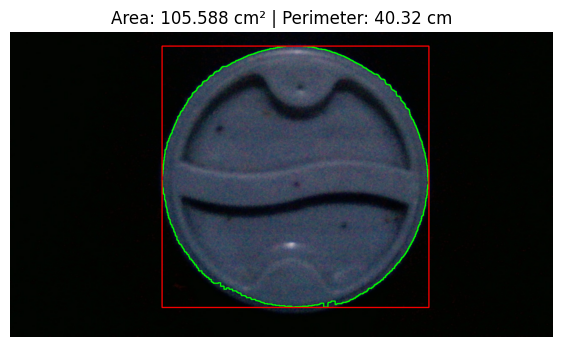

In [12]:
output = image_rgb.copy()

# Draw contour
cv2.drawContours(output, [largest_contour], -1, (0, 255, 0), 2)

# Draw bounding box
cv2.rectangle(output, (x, y), (x+w, y+h), (255, 0, 0), 2)

plt.figure(figsize=(7,7))
plt.imshow(output)
plt.title(
    f"Area: {area_cm2:.3f} cm² | Perimeter: {perimeter_cm:.2f} cm"
)
plt.axis("off")
plt.show()
